In [42]:
%%javascript
MathJax.Hub.Config({
    TeX: { equationNumbers: { autoNumber: "AMS" } }
});



<IPython.core.display.Javascript object>

# Numerical Solution for the Diffusion Equation in One Dimension

   In order to replicate the analysis presented in Moorcroft & Barnett (2008), I began by seeking a numerical solution to the diffusion equation in one dimension. The first step in this process was to discretize the domain using a set of equally spaced mesh points given by:
   
$$x_i = i\Delta x,      i=0,...,N_x,$$
$$t_j = j \Delta t,     j=0,...,N_t$$ 

After discretizing the domain, I replaced the derivatives in the diffusion equation using finite difference approximations. For the time derivative, I utilized a forward differene approximation given by:

\begin{equation} \frac{\partial u}{\partial t}= \frac {u_{i,j+1} - u_{i,j}}{\Delta t} \end{equation}

For the space derivative, I utilized a centeral difference approximation given by:

\begin{equation}  \frac{{\partial}^2 u}{\partial {x}^2}= \frac {u_{i+1,j} - 2u_{i,j} + u_{i-1,j}}{\Delta x^2} \end{equation}

After substituting these approximations into the the diffusion equation, I was left with the following:

\begin{equation} \frac {u_{i,j+1} - u_{i,j}}{\Delta t} = k \left(\frac {u_{i+1,j} - 2u_{i,j} + u_{i-1,j}}{\Delta x^2}\right) \end{equation}

Finally, rearranging terms produced the following finite difference scheme for the numerical solution to the diffusion equation in one dimension:

 \begin{equation} u_{i,j+1} = u_{i,j} + r(u_{i+1,j} -2u_{i,j} + u_{i-1,j}) \end{equation}

Where $r$, the Fourier number, is given by:

$$r = k \left(\frac {\Delta t}{\Delta x^2}\right)$$

Using Python version 3.9.13, I implemented the finite difference scheme described above to numerically solve the diffusion equation in one dimension. The Python script that I wrote for this purpose is described in detail below. 

The script utilizes the modules numpy, math, and matplotlib (for visualization). 

In [43]:
import numpy as np
import math
from matplotlib import pyplot as plt


After importing the required modules, the next step is to specify the bounds of the spatial domain, the bounds of the time domain, $\Delta t$, $\Delta x$, and the mean step length of the animal. Here, I set the bounds of the spatial domain to be $[0,20]$, the bounds of the time domain to be $[0,500]$, $\Delta t$ to be 0.01, and $\Delta x$ to be 0.05.

Additionally, the mean step length of the animal is assumed to be 0.04. Ideally, the mean step length of the animal should be obtained from observations of the animal's movement in the wild (Conversation with Paul Moorcroft). In the absence of movement data, a "realistic" choice for the mean step length can be used (Conversation with Paul Moorcroft). If we assume here that $\Delta t$ has units of hours and $\Delta x$ has units of kilometers, then a mean step length of 0.04 would correspond to a movement speed of $4 \frac{km}{hour}$. Depending on the animal, a movement speed of $4 \frac{km}{hour}$ may or may not be realistic.

In [44]:
# Domain Bounds
start = 0 # start bound
stop = 20 # stop bound

In [45]:
# Model Parameters
dt = 0.01 # delta t
T = 500 # total time
Nt = int(T / dt)  # number of time steps
dx = 0.05  # delta x
Nx = int((abs(stop-start))/dx)  # number of x steps
mean_sl = 0.04 # mean step length of the animal
k = (mean_sl**2)/2/dt # diffusion coefficient equal to mean step length squared
r = k * dt / dx / dx  # Fourier number

The stability of the finite difference scheme is sensitive to certian choices of $\Delta t$, $\Delta x$, and mean step length. In order to avoid numerical instability, the fourier number, $r$, must obey the following inequality:

$$r = k \left(\frac {\Delta t}{\Delta x^2}\right) < \frac{1}{2}$$

As such, the Python script contains a flag to warn the user if the current choices of $\Delta t$, $\Delta x$, and mean step length will yield numerical instability.

In [46]:
# Fourier number flag
if r > 0.5:
    print("WARNING: Fourier number > 0.5")

After specifying the model parameters and checking that the stability conditions are satisfied, the spatial and temporal domains are discretized using a numpy array. The number of rows in the array are given by the number of time-steps, $N_t$, as specified above. The number of columns in the array are given by the number of x-steps, $N_x$, also specified above. In each cell of the array, the spatial position, $x_i$, and the probability density at position $x_i$ and time $t_j$, given by $u(x_i,t_j)$, are stored.

In [47]:
# Initializing x values where u(x,t) will be calculated
Xs = np.arange(start, stop + dx, dx)

In [48]:
# Initializing array with Nt rows, Nx columns, and [x,u(x,t)] per cell
u = np.zeros((Nt, 2, len(Xs)))

# Populating x values in array u
for j in range(0, Nt):
    u[j][0]=Xs

For the inital conditions, I chose to use a gaussian function defined by $\mu = 10$ and $\sigma = 0.5$. Because this script models the evolution of a probability density function, a guassian initial condition is appropriate because guassian functions always integrate to 1.  

In [49]:
# Gaussian function used to specify initial conditions
def gaussian(x, mu, sigma):
    denom = sigma * ((2 * math.pi)**0.5)
    numerator = math.exp(((x - mu)**2) / ((sigma) **2) / -2)
    res = numerator / denom
    return res 

# Specifying inital condition
IC=[]
for i in range(0, len(Xs)):
    x = Xs[i]
    res = gaussian(x = x,
                   mu = 10,
                   sigma = 0.5) 
    res = np.float64(res)
    IC.append(res)
u[0][1] = IC 

After discretizng the temporal and spatial domains as well as specifying the inital conditions, the script numerically solves for $u(x,t)$ at future timesetps uisng the finite difference scheme described by Equation 4. When executing the finite difference scheme in Equation 4, the choice of boundary conditions is extremely important. Dirichlet boundary conidions should be avoided because such boundary conditions do not allow for conservation of area on the curve. Because we are modeling the evolution of a probability density function, the area under the curve should always be equal to 1. Zero-flux neumann boundary conditions are more appropriate choice, as they allow for conservation of area under the curve, but such boundary conditions are difficult to execute in code. 

Here, I opted to use periodic boundary conditions. Like the neumann conditions, periodic boundary conditions allow for the area under the curve to be conserved which is necessary when modeling the evolution of a probability density function. However, it should be noted that periodic boundary conditions may be unlikely in a biological context due to the fact that the bounds of the domain are assumed to be physically connected. 

In [50]:
# Explicit finite difference scheme for diffusion
for j in range(0,Nt-1):
    for i in range(0,Nx+1):
        if i == 0:
            u[j + 1][1][i] = u[j][1][i] + r * (u[j][1][i + 1] - 2 * u[j][1][i] + u[j][1][Nx])
        elif i == Nx:
            u[j + 1][1][i] = u[j][1][i] + r * (u[j][1][0] - 2 * u[j][1][i] + u[j][1][i - 1])
        else:
            u[j + 1][1][i] = u[j][1][i] + r * (u[j][1][i + 1] - 2 * u[j][1][i] + u[j][1][i - 1])

<IPython.core.display.Javascript object>


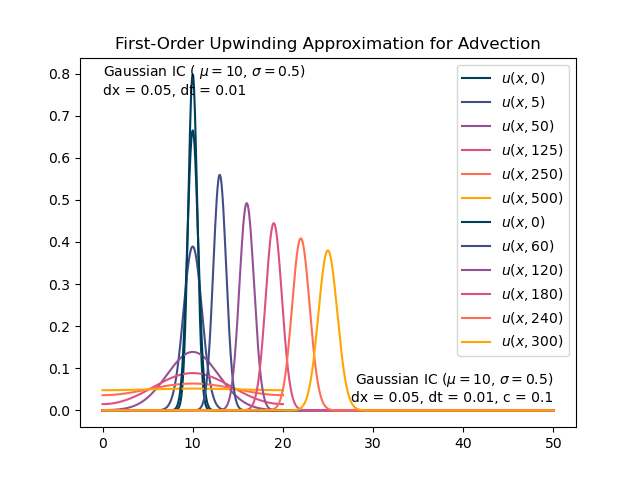

Text(0.5, 1.0, 'Diffusion')

In [51]:
# Diffusion Plot
t0 = u[0][1]
t1 = u[int(0.01*Nt)][1]
t2 = u[int(0.1*Nt)][1]
t3 = u[int(0.25*Nt)][1]
t4 = u[int(0.5*Nt)][1]
t5 = u[int(Nt-1)][1]

plt.plot(Xs,t0, label = r'$u(x,0)$', color = "#003f5c" )
plt.plot(Xs,t1, label = fr'$u(x,{int(0.01*T)})$', color = "#444e86")
plt.plot(Xs,t2, label = fr'$u(x,{int(0.1*T)})$', color = "#955196")
plt.plot(Xs,t3, label = fr'$u(x,{int(0.25*T)})$', color = "#dd5182")
plt.plot(Xs,t4, label = fr'$u(x,{int(0.5*T)})$', color = "#ff6e54")
plt.plot(Xs,t5, label =fr'$u(x,{int(T)})$', color = "#ffa600")
plt.legend(loc="upper right")
plt.text(0,0.75,"Gaussian IC ( " + r'$\mu = 10$' + ", " + r'$\sigma = 0.5)$' + f"\ndx = {dx}, dt = {dt}")
plt.title("Diffusion")



Figure 1 shows numerical solutions of $u(x,t)$ generated by Equation 4 at $t = 5, t = 50, t = 125, t = 250,$ and $t = 500$ as well as the inital condition at $t = 0$. By $t = 300$, $u(x,t)$ appears to have flattened out which is expected when movement is only due to diffusive flux. Additionally, calculations of the integral of $u(x,t)$ at $t = 5, t = 50, t = 125, t = 250,$ and $t = 500$ reveal only a slight loss of area under the curve with each time step.  

In [11]:
# Integration function using the trapezoid method
def integrate(u,dx,x_vals):
    area_under_curve = 0
    for i in range(0,len(x_vals)-1):
        area = dx * (u[i+1]+u[i]) / 2
        area_under_curve = area_under_curve + area
    return area_under_curve

# Checking for conservation
for j in range(0,Nt):
    t  = (j+1)/Nt*T
    step = 0.2 * T
    if t % step == 0 or j == 0:
        res = integrate(u = u[j][1],
                  dx = dx,
                  x_vals = Xs)
        print(f"Area under u(x,{int(t)}) = {res}")

Area under u(x,0) = 1.0000000000000004
Area under u(x,100) = 0.9995508154016008
Area under u(x,200) = 0.9985210787796398
Area under u(x,300) = 0.9979724740159428
Area under u(x,400) = 0.9977189148875474
Area under u(x,500) = 0.9976031859309636


After developing a numerical solver for the diffusion equation in one dimension, the next step in replicating the findings of Moorcroft & Barnett 2008 was to develop a process for numerically solving the advection equation in one dimension. Details on the development of a numerical solution for the advection equation in one dimension are described in the following section.

# Numerical Solution for the Advection Equation in One Dimension

While Moorcroft & Barnett (2008) defines advection speed based on the spatial distribution of resources, I started with the simpler case of moedling advection with constant speed. 

## Advection with constant speed

The process used to construct a numerical solution for the advection equation with constant speed is highly similar to the process I used to construct a numerical solution for the diffusion equation which I desribed in the previous section. First, I discretized my domain using a set of equally spaced mesh points in the same way that I did for the diffusion equation. Similarly, I then replaced the derivatives in the advection equation using finite difference approximations. As I did for the diffusion equation, I used a forward difference approximation for the time derivate (Equation 1). However, unlike the central difference approximation that I used for the spatial derivative in the diffusion equation, I approximated the spatial derivative in the advection equation using an upwinding approach. My first attempt at numerically solving the advection equation relied on a first-order upwinding approximation for the spatial derivative given by:

\begin{equation} \frac{\partial u}{\partial x} = \frac {u_{i,j} - u_{i-1,j}}{\Delta x} \; \; \text{if c > 0}\end{equation}

\begin{equation} \frac{\partial u}{\partial x} = \frac {u_{i+1,j} - u_{i,j}}{\Delta x} \; \; \text{if c < 0}\end{equation}

Which substituting into the PDE along with the forward difference approximation of the time derivative yielded:

\begin{equation} \frac {u_{i,j+1} - u_{i,j}}{\Delta t} = -c \left(\frac {u_{i,j} - u_{i-1,j}}{\Delta x}\right) \; \; \text{if c > 0} \end{equation}

\begin{equation} \frac {u_{i,j+1} - u_{i,j}}{\Delta t} = -c \left(\frac {u_{i+1,j} - u_{i,j}}{\Delta x}\right) \; \; \text{if c < 0} \end{equation}

Finally, re-arranging terms produced the following finite difference scheme for the numerical solution of the advection equation in one dimension:

\begin{equation} u_{i,j+1} = u_{i,j} - \rho (u_{i,j} - u_{i-1,j}) \; \; \text{if c > 0}\end{equation}

\begin{equation} u_{i,j+1} = u_{i,j} - \rho (u_{i+1,j} - u_{i,j}) \; \; \text{if c < 0}\end{equation}

Where $\rho$, the Courant number, is given by:

$$\rho = c \left(\frac {\Delta t}{\Delta x}\right)$$

After defining the finite difference scheme that will be used to numerically solve the advection equation in one dimension, I then had to specify the bounds the spatial domain, the bounds of the time domain, $\Delta t$, $\Delta x$, and the velocity of the animal. Here, I set the bounds of the spatial domain to be $[0,50]$, the bounds of the time domain to be $[0,300]$, $\Delta t$ to be $0.01$, $\Delta x$ to be $0.05$, and velocity, $c$, to be $0.1$.

In [52]:
# Bounds
start = 0 # start bound
stop = 50 # stop bound

In [53]:
# Model parameters
dt = 0.01 # delta t
dx = 0.05  # delta x
T = 300 # Total time
Nt = int(T / dt)  # Number of time steps
Nx = int((abs(stop-start))/dx)  # Number of x steps
c = 0.1 # advections speed
p = c * dt / dx /2 # courant number

Like the finite difference scheme for the diffusion equation described above, the stability of the finite difference scheme for the advection equation is sensitive to choices of various inputs. Specifically, the finite difference scheme for the advection equation is sensitive to certain choices for $\Delta t$, $\Delta x$, and $c$. In order to avoid numerical instability, the Courant number, $\rho$, must obey the following inequality:

$$\rho = c \left(\frac {\Delta t}{\Delta x}\right) < 1$$

As such, the Python script contains a flag to warn the user if the current values of $\Delta t$, $\Delta x$, and  $c$ will yield numerical instability.

In [54]:
# CFL flag
if p > 1:
    print("WARNING: Courant number > 1")

In an identical fashion to the diffusion example described in the previous section, the spatial and temporal domains are discretized using a numpy array with $N_t$ rows, $N_x$ columns. In each cell of the array, the spatial position, $x_i$, and the probability density at position $x_i$ and time $t_j$, $u(x_i,t_j)$, are stored. Additionally, I continued to use a guassian initial condition, this time with $\mu = 10$ and $\sigma = 0.6$

In [55]:
# Initializing x values where u(x,t) will be calculated
Xs = np.arange(start, stop + dx, dx)

In [56]:
# Initializing array with Nt, Nx columns, and [x,u(x,t)] per cell
u = np.zeros((Nt, 2, len(Xs)))

# Populating x values in array u
for j in range(0, Nt):
    u[j][0]=Xs

In [57]:
# Specifing inital condition
IC=[]
for i in range(0, len(Xs)):
    x = Xs[i]
    res = gaussian(x = x,
                   mu = 10,
                   sigma = 0.6) 
    res = np.float64(res)
    IC.append(res)
u[0][1] = IC 

After discretizng the temporal and spatial domains as well as specifying the inital conditions, the script numerically solves for $u(x,t)$ at future timesetps uisng the finite difference scheme described by Equations 9 and 10. Like in the finite difference scheme for the diffusion equation, the finite difference shceme for the advection equation utilizes periodic boundary conditions. 

In [58]:
# First-order upwinding scheme
for j in range(0,Nt-1):
    for i in range(0,Nx+1):
        if i == 0:
            u[j+1][1][i] = u[j][1][i] - p * (u[j][1][i] - u[j][1][-1])
        else:
            u[j + 1][1][i] = u[j][1][i] - p * (u[j][1][i] - u[j][1][i - 1])

### First-Order Upwinding Approach

In [59]:
# First-order upwinding scheme advection plot
t0 = u[0][1]
t1 = u[int(0.2*Nt)][1]
t2 = u[int(0.4*Nt)][1]
t3 = u[int(0.6*Nt)][1]
t4 = u[int(0.8*Nt)][1]
t5 = u[int(Nt-1)][1]

plt.plot(Xs,t0, label = r'$u(x,0)$', color = "#003f5c" )
plt.plot(Xs,t1, label = fr'$u(x,{int(0.2*T)})$', color = "#444e86")
plt.plot(Xs,t2, label = fr'$u(x,{int(0.4*T)})$', color = "#955196")
plt.plot(Xs,t3, label = fr'$u(x,{int(0.6*T)})$', color = "#dd5182")
plt.plot(Xs,t4, label = fr'$u(x,{int(0.8*T)})$', color = "#ff6e54")
plt.plot(Xs,t5, label =fr'$u(x,{int(T)})$', color = "#ffa600")
plt.legend(loc="upper right")
plt.text(50,0.02,"Gaussian IC (" + r'$\mu = 10$' + ", " + r'$\sigma = 0.5)$' + f"\ndx = {dx}, dt = {dt}, c = {c}", ha = 'right')
plt.title("First-Order Upwinding Approximation for Advection")


Text(0.5, 1.0, 'First-Order Upwinding Approximation for Advection')

In [60]:
# Checking for conservation
for j in range(0,Nt):
    t  = (j+1)/Nt*T
    step = 0.2 * T
    if t % step == 0 or j == 0:
        res = integrate(u = u[j][1],
                  dx = dx,
                  x_vals = Xs)
        print(f"Area under u(x,{int(t)}) = {res}")

Area under u(x,0) = 0.9999999999999998
Area under u(x,60) = 1.0
Area under u(x,120) = 1.0
Area under u(x,180) = 1.0
Area under u(x,240) = 1.0000000000000002
Area under u(x,300) = 1.0000000000000002


Figure 1 shows numerical solutions of  𝑢(𝑥,𝑡)  generated by Equation 4 at  𝑡=5,𝑡=50,𝑡=125,𝑡=250,  and  𝑡=500  as well as the inital condition at  𝑡=0 . 

### Second-Order Upwinding Approach

In [21]:
# Second-order upwinding approach
for j in range(0,Nt-1):
    for i in range(0,Nx+1):
        if c > 0:
            if i == 0:
                u[j + 1][1][i] = -p * (3*u[j][1][i] - 4 * u[j][1][Nx] + u[j][1][Nx-1]) + u[j][1][i]
            elif i == 1:
                u[j + 1][1][i] = -p * (3 * u[j][1][i] - 4 * u[j][1][i - 1] + u[j][1][Nx]) + u[j][1][i]
            else:
                u[j + 1][1][i] = -p * (3*u[j][1][i] - 4 * u[j][1][i-1] + u[j][1][i-2]) + u[j][1][i]
        else:
            if i == Nx:
                u[j + 1][1][i] = u[j][1][i] - p * (-u[j][1][1] + 4 * u[j][1][0] - 3 * u[j][1][Nx])
            elif i == (Nx-1):
                u[j + 1][1][i] = u[j][1][i] - p * (-u[j][1][0] + 4 * u[j][1][Nx] - 3 * u[j][1][Nx-1])
            else:
                u[j + 1][1][i] = u[j][1][i] - p * (-u[j][1][i+2] + 4 * u[j][1][i + 1] - 3 * u[j][1][i])

In [22]:
# Second-order upwinding scheme advection plot
t0 = u[0][1]
t1 = u[int(0.2*Nt)][1]
t2 = u[int(0.4*Nt)][1]
t3 = u[int(0.6*Nt)][1]
t4 = u[int(0.8*Nt)][1]
t5 = u[int(Nt-1)][1]

plt.plot(Xs,t0, label = r'$u(x,0)$', color = "#003f5c" )
plt.plot(Xs,t1, label = fr'$u(x,{int(0.2*T)})$', color = "#444e86")
plt.plot(Xs,t2, label = fr'$u(x,{int(0.4*T)})$', color = "#955196")
plt.plot(Xs,t3, label = fr'$u(x,{int(0.6*T)})$', color = "#dd5182")
plt.plot(Xs,t4, label = fr'$u(x,{int(0.8*T)})$', color = "#ff6e54")
plt.plot(Xs,t5, label =fr'$u(x,{int(T)})$', color = "#ffa600")
plt.legend(loc="upper right")
plt.text(-4.5,0.71,"Gaussian IC (" + r'$\mu = 10$' + 
         ", " + r'$\sigma = 0.5)$' + f"\ndx = {dx}, dt = {dt}, c = {c}", ha = 'left')
plt.title("Second-Order Upwinding Approximation for Advection")
plt.ylim([-0.1,0.8])
plt.xlim([-5,56])
plt.show()

In [23]:
# Checking for conservation
for j in range(0,Nt):
    t  = (j+1)/Nt*T
    step = 0.2 * T
    if t % step == 0 or j == 0:
        res = integrate(u = u[j][1],
                  dx = dx,
                  x_vals = Xs)
        print(f"Area under u(x,{int(t)}) = {res}")

Area under u(x,0) = 0.9999999999999998
Area under u(x,60) = 0.9999999999999993
Area under u(x,120) = 1.0000000000000002
Area under u(x,180) = 1.0000000000000013
Area under u(x,240) = 1.0000000000000002
Area under u(x,300) = 0.9999999999999998


## Advection with Variable Speed

In [24]:
# Habitat Preference
def preference(x):
    pi = math.pi
    res = 0.1 + math.sin(2 * pi * x / 50) ** 2 
    return res

# Derivative of Habitat Preference Function
def preference_slope(x):
    pi = math.pi
    res = (2 * pi / 25) * math.cos(pi * x / 25) * math.sin(pi * x / 25)
    return res

In [25]:
#Habitat Preference Function
w = np.zeros((1,2,len(Xs)))
w[0][0] = Xs
for i in range(0,len(Xs)):
    w[0][1][i] = preference(w[0][0][i])

#Spatial Derivative of Habitat Preference Function
wx = np.zeros((1,2,len(Xs)))
wx[0][0] = Xs
for i in range(0,len(Xs)):
    wx[0][1][i] = preference_slope(w[0][0][i])

In [26]:
# Specifing inital condition
IC=[]
for i in range(0, len(Xs)):
    x = Xs[i]
    res = gaussian(x = x,
                   mu = 23,
                   sigma = 0.6) 
    res = np.float64(res)
    IC.append(res)
u[0][1] = IC 

In [27]:
for j in range(0,Nt-1):
    for i in range(0,Nx+1):
        c = (mean_sl**2) * wx[0][1][i] / w[0][1][i] / dt  # Advection coefficient
        p = c * dt / dx /2 # Courant number
        if c > 0:
            if i == 0:
                u[j + 1][1][i] = -p * (3*u[j][1][i] - 4 * u[j][1][Nx] + u[j][1][Nx-1]) + u[j][1][i]
            elif i == 1:
                u[j + 1][1][i] = -p * (3 * u[j][1][i] - 4 * u[j][1][i - 1] + u[j][1][Nx]) + u[j][1][i]
            else:
                u[j + 1][1][i] = -p * (3*u[j][1][i] - 4 * u[j][1][i-1] + u[j][1][i-2]) + u[j][1][i]
        else:
            if i == Nx:
                u[j + 1][1][i] = u[j][1][i] - p * (-u[j][1][1] + 4 * u[j][1][0] - 3 * u[j][1][Nx])
            elif i == (Nx-1):
                u[j + 1][1][i] = u[j][1][i] - p * (-u[j][1][0] + 4 * u[j][1][Nx] - 3 * u[j][1][Nx-1])
            else:
                u[j + 1][1][i] = u[j][1][i] - p * (-u[j][1][i+2] + 4 * u[j][1][i + 1] - 3 * u[j][1][i])

In [28]:
# Advection with variable speed
t0 = u[0][1]
t1 = u[int(0.2*Nt)][1]
t2 = u[int(0.4*Nt)][1]
t3 = u[int(0.6*Nt)][1]
t4 = u[int(0.8*Nt)][1]
t5 = u[int(Nt-1)][1]

plt.plot(Xs,w[0][1], color = "#5a5a5a", label = r"$\mathrm{w(x)}$", linestyle = "dashed")
plt.plot(Xs,t0, label = 'u(x,0)', color = "#003f5c" )
plt.plot(Xs,t1, label = f'u(x,{int(0.2*T)})', color = "#444e86")
plt.plot(Xs,t2, label = f'u(x,{int(0.4*T)})', color = "#955196")
plt.plot(Xs,t3, label = f'u(x,{int(0.6*T)})', color = "#dd5182")
plt.plot(Xs,t4, label = f'u(x,{int(0.8*T)})', color = "#ff6e54")
plt.plot(Xs,t5, label =f'u(x,{int(T)})', color = "#ffa600")
plt.legend(loc="upper right")
plt.text(29.9,-0.5,"w(x)="+
         "Gaussian IC (" + r'$\mu = 23$' + ", " + r'$\sigma = 0.5)$' + 
         f"\ndx = {dx}, dt = {dt}", ha = 'right')
plt.title("Advection with Variable Speed")
plt.xlim([10,30])
plt.show()

In [29]:
# Checking for conservation
for j in range(0,Nt):
    t  = (j+1)/Nt*T
    step = 0.2 * T
    if t % step == 0 or j == 0:
        res = integrate(u = u[j][1],
                  dx = dx,
                  x_vals = Xs)
        print(f"Area under u(x,{int(t)}) = {res}")

Area under u(x,0) = 1.0000000000000002
Area under u(x,60) = 0.7792795317052899
Area under u(x,120) = 0.5287335829487156
Area under u(x,180) = 0.38943306821815143
Area under u(x,240) = 0.3007411616552028
Area under u(x,300) = 0.23959897942307748


## Modified advection scheme

In [30]:
# Second-order upwinding approach with normalization by area under the curve
for j in range(0,Nt-1):
    for i in range(0,Nx+1):
        c = (mean_sl**2) * wx[0][1][i] / w[0][1][i] / dt  # Advection coefficient
        p = c * dt / dx /2 # Courant number
        if c > 0:
            if i == 0:
                u[j + 1][1][i] = -p * (3*u[j][1][i] - 4 * u[j][1][Nx] + u[j][1][Nx-1]) + u[j][1][i]
            elif i == 1:
                u[j + 1][1][i] = -p * (3 * u[j][1][i] - 4 * u[j][1][i - 1] + u[j][1][Nx]) + u[j][1][i]
            else:
                u[j + 1][1][i] = -p * (3*u[j][1][i] - 4 * u[j][1][i-1] + u[j][1][i-2]) + u[j][1][i]
        else:
            if i == Nx:
                u[j + 1][1][i] = u[j][1][i] - p * (-u[j][1][1] + 4 * u[j][1][0] - 3 * u[j][1][Nx])
            elif i == (Nx-1):
                u[j + 1][1][i] = u[j][1][i] - p * (-u[j][1][0] + 4 * u[j][1][Nx] - 3 * u[j][1][Nx-1])
            else:
                u[j + 1][1][i] = u[j][1][i] - p * (-u[j][1][i+2] + 4 * u[j][1][i + 1] - 3 * u[j][1][i])
    area = integrate(u = u[j + 1][1],
                     dx = dx,
                     x_vals = Xs)
    u[j+1][1] = u[j+1][1]/area

In [31]:
# Advection with variable speed
# Density is normalized by the area under the curve
t0 = u[0][1]
t1 = u[int(0.2*Nt)][1]
t2 = u[int(0.4*Nt)][1]
t3 = u[int(0.6*Nt)][1]
t4 = u[int(0.8*Nt)][1]
t5 = u[int(Nt-1)][1]

plt.plot(Xs,w[0][1], color = "#5a5a5a", label = r"$\mathrm{w(x)}$", linestyle = "dashed")
plt.plot(Xs,t0, label = 'u(x,0)', color = "#003f5c" )
plt.plot(Xs,t1, label = f'u(x,{int(0.2*T)})', color = "#444e86")
plt.plot(Xs,t2, label = f'u(x,{int(0.4*T)})', color = "#955196")
plt.plot(Xs,t3, label = f'u(x,{int(0.6*T)})', color = "#dd5182")
plt.plot(Xs,t4, label = f'u(x,{int(0.8*T)})', color = "#ff6e54")
plt.plot(Xs,t5, label =f'u(x,{int(T)})', color = "#ffa600")
plt.legend(loc="upper right")
plt.text(29.9,-0.5,"Gaussian IC (" + r'$\mu = 23$' + ", "
         + r'$\sigma = 0.5)$' + f"\ndx = {dx}, dt = {dt}", ha = 'right')
plt.title("Advection with variable speed")
plt.xlim([10,30])
plt.show()

In [32]:
# Checking for conservation
for j in range(0,Nt):
    t  = (j+1)/Nt*T
    step = 0.2 * T
    if t % step == 0 or j == 0:
        res = integrate(u = u[j][1],
                  dx = dx,
                  x_vals = Xs)
        print(f"Area under u(x,{int(t)}) = {res}")

Area under u(x,0) = 1.0000000000000002
Area under u(x,60) = 0.9999999999999989
Area under u(x,120) = 0.9999999999999992
Area under u(x,180) = 1.0000000000000002
Area under u(x,240) = 1.0000000000000009
Area under u(x,300) = 1.0000000000000002


# Advection and Diffusion

In [33]:
# Bounds
start = 0 # start bound
stop = 50 # stop bound

In [34]:
# Model parameters
dt = 0.01 # delta t
dx = 0.05  # delta x
T = 1000 # Total time
Nt = int(T / dt)  # Number of time steps
Nx = int((abs(stop-start))/dx)  # Number of x steps
mean_sl = 0.04 #mean step length
k = (mean_sl**2)/2/dt # diffusion coefficient equal to mean step length squared
r = k * dt / dx / dx  # Fourier number

In [35]:
# CFL flag
if r > 0.5:
    print("WARNING: Fourier number > 0.5")

In [36]:
# Initializing x values where u(x,t) will be calculated
Xs = np.arange(start, stop + dx, dx)

# Initializing array with Nt row, Nx columns, and [x,u(x,t)] per cell
u = np.zeros((Nt, 2, len(Xs)))

# Populating x values in array u
for j in range(0, Nt):
    u[j][0]=Xs

In [37]:
def preference(x):
    pi = math.pi
    res = 0.1 + math.sin(2 * pi * x / 50) ** 2  # w1
    res = np.float64(res)
    return res

# Derivative of Habitat Preference Function
def preference_slope(x):
    pi = math.pi
    res = (2 * pi / 25) * math.cos(pi * x / 25) * math.sin(pi * x / 25)  # w1
    res = np.float64(res)
    return res

In [38]:
#Habitat Preference Function
w = np.zeros((1,2,len(Xs)))
w[0][0] = Xs
for i in range(0,len(Xs)):
    w[0][1][i] = preference(w[0][0][i])

#Spatial Derivative of Habitat Preference Function
wx = np.zeros((1,2,len(Xs)))
wx[0][0] = Xs
for i in range(0,len(Xs)):
    wx[0][1][i] = preference_slope(w[0][0][i])

# Populating x values in array u
for j in range(0, Nt):
    u[j][0]=Xs

In [39]:
#Setting Initial Condition
IC=[]
for i in range(0, len(Xs)):
    x = Xs[i]
    res = gaussian(x = x,
                   mu = 28,
                   sigma = 0.5) #Gaussin IC
    res = np.float64(res)
    IC.append(res)
u[0][1] = IC #Populating initial condition in array u

In [40]:
# Finite difference scheme for advection and diffusion
for j in range(0,Nt-1):
    for i in range(0,Nx+1):
        c = (mean_sl**2) * wx[0][1][i] / w[0][1][i] / dt  # Advection coefficient
        p = c * dt / dx /2 # Courant number
        if p > 1: # CFL flag
            print("WARNING: Courant number > 1")
        if c > 0:
            if i == 0:
                u[j + 1][1][i] = r * (u[j][1][i + 1] - 2 * u[j][1][i] + u[j][1][Nx]) -p * (3*u[j][1][i] - 4 * u[j][1][Nx] + u[j][1][Nx-1]) + u[j][1][i]
            elif i == 1:
                u[j + 1][1][i] = r * (u[j][1][i + 1] - 2 * u[j][1][i] + u[j][1][i - 1]) -p * (3 * u[j][1][i] - 4 * u[j][1][i - 1] + u[j][1][Nx]) + u[j][1][i]
            elif i == Nx:
                u[j + 1][1][i] = r * (u[j][1][0] - 2 * u[j][1][i] + u[j][1][i - 1]) - p * (3 * u[j][1][i] - 4 * u[j][1][i - 1] + u[j][1][i - 2]) + u[j][1][i]
            else:
                u[j + 1][1][i] = r * (u[j][1][i + 1] - 2 * u[j][1][i] + u[j][1][i - 1]) -p * (3*u[j][1][i] - 4 * u[j][1][i-1] + u[j][1][i-2]) + u[j][1][i]
        else:
            if i == Nx:
                u[j + 1][1][i] = u[j][1][i] - p * (-u[j][1][1] + 4 * u[j][1][0] - 3 * u[j][1][Nx]) + r * (u[j][1][0] - 2 * u[j][1][i] + u[j][1][i - 1])
            elif i == (Nx-1):
                u[j + 1][1][i] = u[j][1][i] - p * (-u[j][1][0] + 4 * u[j][1][Nx] - 3 * u[j][1][Nx-1]) + r * (u[j][1][i + 1] - 2 * u[j][1][i] + u[j][1][i - 1])
            elif i == 0:
                u[j + 1][1][i] = u[j][1][i] - p * (-u[j][1][i + 2] + 4 * u[j][1][i + 1] - 3 * u[j][1][i]) + r * (u[j][1][i + 1] - 2 * u[j][1][i] + u[j][1][Nx])
            else:
                u[j + 1][1][i] = u[j][1][i] - p * (-u[j][1][i+2] + 4 * u[j][1][i + 1] - 3 * u[j][1][i]) + r * (u[j][1][i + 1] - 2 * u[j][1][i] + u[j][1][i - 1])
    area = integrate(u = u[j + 1][1],
                     dx = dx,
                     x_vals = Xs)
    u[j+1][1] = u[j+1][1]/area

In [41]:
# Advection with variable speed
t0 = u[0][1]
t1 = u[int(0.2*Nt)][1]
t2 = u[int(0.4*Nt)][1]
t3 = u[int(0.6*Nt)][1]
t4 = u[int(0.8*Nt)][1]
t5 = u[int(Nt-1)][1]

plt.plot(Xs,w[0][1], color = "#5a5a5a", label = r"$\mathrm{w(x)}$", linestyle = "dashed")
plt.plot(Xs,t0, label = 'u(x,0)', color = "#003f5c" )
plt.plot(Xs,t1, label = f'u(x,{int(0.2*T)})', color = "#444e86")
plt.plot(Xs,t2, label = f'u(x,{int(0.4*T)})', color = "#955196")
plt.plot(Xs,t3, label = f'u(x,{int(0.6*T)})', color = "#dd5182")
plt.plot(Xs,t4, label = f'u(x,{int(0.8*T)})', color = "#ff6e54")
plt.plot(Xs,t5, label =f'u(x,{int(T)})', color = "#ffa600")
plt.legend(loc="upper right")
plt.text(29.9,-0.5,"Gaussian IC (" + r'$\mu = 28$' + ", "
         + r'$\sigma = 0.5)$' + f"\ndx = {dx}, dt = {dt}", ha = 'right')
plt.title("Advection with variable speed")
plt.show()